## Recommendation Engine With Collaborative Filtering

This project is aimed to build a collaborative filtering system on data with user/customer ratings. This notebook explores the basic use of Surprise Library, and using GridSearch CV for tuning hyper-parameters. The datasets involved in this project are MovieLens-100k, MovieLends - 20M and Amazon Moving Ratings.

### Import Libraries

In [4]:
import numpy as np
import pandas as pd
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import Reader

# Centered consine similarity algorithm, taking into account the mean ratings of each user
from surprise import KNNWithMeans

### Try the built-in dataset

In [5]:
# load the surprise library build-in dataset
built_in_data = Dataset.load_builtin("ml-100k")

# Setting parameters for grid search for techinique optimization
sim_options = {
    "name": ["cosine","msd","pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

# Load grid search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3, n_jobs=8) # n_jobs is to define how many CPU threads can be used 
gs.fit(built_in_data)

# print the rmse and the best method to use for prediction
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9439556831534365
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}


For the MovieLens 100k dataset above, Centered-KNN algorithm works best if you go with >>item-based approach<< and use >>msd<< as the similarity metric with minimum support >>3<<.

### Load the Movie-20M dataset

In [36]:
# First step is to load the data to pd.dataframe
df = pd.read_csv('MovieLens_ratings.csv')
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [23]:
df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [24]:
# A reader is needed to define the scale of the rating
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (order matters).
data_20m = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [25]:
# Setting parameters for grid search for technique optimization
sim_options = {
    "name": ["cosine","msd","pearson"],  # similarity metric to use
    "min_support": [3, 4, 5],  # minimum number of common items needed between users
    "user_based": [False, True],  # whether the approach will be user-based or item-based
}

param_grid = {"sim_options": sim_options}

# Load grid search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3, n_jobs=8)
gs.fit(data_20m)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9021683719270451
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}


For the MovieLens 20M dataset, Centered-KNN algorithm works best if you go with >>user-based<< approach and use >>msd<< as the similarity metric with minimum support >>3<<.

### Configure the KNNWithMeans function

In [76]:
# Recommender function
from surprise import KNNWithMeans

# To use user-based msd similarity
sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}
algo = KNNWithMeans(sim_options=sim_options)

In [77]:
#from surprise.model_selection import cross_validate
#cross_validate(algo, data_20m, measures=['RMSE'], cv=3, verbose=False)

In [78]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data_20m, test_size=0.2)

In [79]:
# train the data
algo.fit(trainset)
# preditions
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [82]:
pred = pd.DataFrame(predictions)
pred

,uid,iid,r_ui,est,details
0,19,1906,2.0,3.501326,"{'was_impossible': True, 'reason': 'User and/o..."
1,610,53468,3.0,3.532025,"{'actual_k': 5, 'was_impossible': False}"
2,453,1210,3.0,4.529392,"{'actual_k': 40, 'was_impossible': False}"
3,405,1214,4.0,4.299926,"{'actual_k': 40, 'was_impossible': False}"
4,232,8874,3.5,3.825155,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
20163,118,2028,4.0,4.275746,"{'actual_k': 40, 'was_impossible': False}"
20164,33,2539,4.0,3.353461,"{'actual_k': 34, 'was_impossible': False}"
20165,96,2571,4.0,4.289195,"{'actual_k': 40, 'was_impossible': False}"
20166,307,24,2.0,2.386560,"{'actual_k': 21, 'was_impossible': False}"


Parameters:	
- uid – The (raw) user id.
- iid – The (raw) item id.
- r_ui (float) – The true rating rui.
- est (float) – The estimated rating r^ui.
- details (dict) – Stores additional details about the prediction that might be useful for later analysis.

In [83]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.8947


0.8947013813605693

In [90]:
pred['error'] = abs(pred['est'] - pred['r_ui'])
pred.sort_values(by='error')[:10]

,uid,iid,r_ui,est,details,error
3195,171,994,5.0,5.0,"{'actual_k': 8, 'was_impossible': False}",0.0
19766,74,6791,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",0.0
5945,307,2332,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",0.0
3255,523,5618,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
7608,30,1291,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
8337,25,58559,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
13549,122,32,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
14706,586,318,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
11005,348,111,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0
17128,30,110,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",0.0


### Analysis on the Amazon Movie Ratings dataset

In [6]:
df_amazon = pd.read_csv('Amazon_Movie_Ratings.csv')
df_amazon.head()

,user_id,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6,Movie7,Movie8,Movie9,...,Movie197,Movie198,Movie199,Movie200,Movie201,Movie202,Movie203,Movie204,Movie205,Movie206
0,A3R5OBKS7OM2IR,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AH3QC2PC1VTGP,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A3LKP6WPMP9UKX,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AVIY68KEPQ5ZD,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A1CV1WROP5KTTW,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Reverse the pivot table
melt_df = df_amazon.melt(
    id_vars= df_amazon.columns[0],
    value_vars=df_amazon.columns[1:],
    var_name='Movie',
    value_name='rating'
)
melt_df.head(10)

,user_id,Movie,rating
0,A3R5OBKS7OM2IR,Movie1,5.0
1,AH3QC2PC1VTGP,Movie1,NaN
2,A3LKP6WPMP9UKX,Movie1,NaN
3,AVIY68KEPQ5ZD,Movie1,NaN
4,A1CV1WROP5KTTW,Movie1,NaN
5,AP57WZ2X4G0AA,Movie1,NaN
6,A3NMBJ2LCRCATT,Movie1,NaN
7,A5Y15SAOMX6XA,Movie1,NaN
8,A3P671HJ32TCSF,Movie1,NaN
9,A3VCKTRD24BG7K,Movie1,NaN


#### Distribution of Movie Ratings

In [11]:
melt_df = melt_df[melt_df.rating.notnull()] # delete the null values
data_cnt = melt_df['rating'].value_counts().sort_index(ascending=False)
data_cnt.index

Float64Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64')

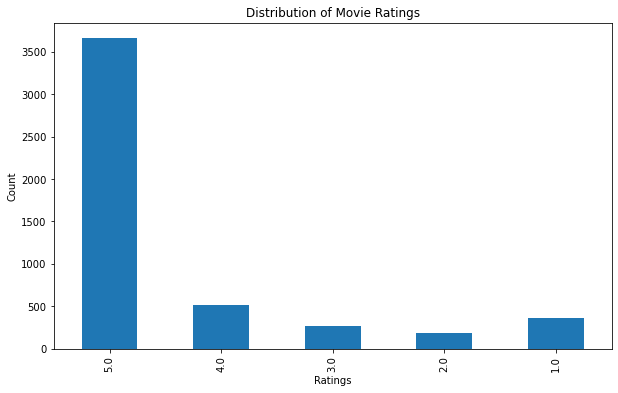

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
data_cnt.plot(kind='bar')
# annotate
plt.title('Distribution of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

It's obvious that most of ratings fall in 5.0

#### Rating distribution by Movie

In [18]:
# Number of ratings per movie
data_cnt1 = melt_df.groupby('Movie')['rating'].count().clip(upper=50)
data_cnt1

Movie
Movie1      1
Movie10     1
Movie100    1
Movie101    5
Movie102    2
           ..
Movie95     6
Movie96     3
Movie97     5
Movie98     1
Movie99     2
Name: rating, Length: 206, dtype: int64

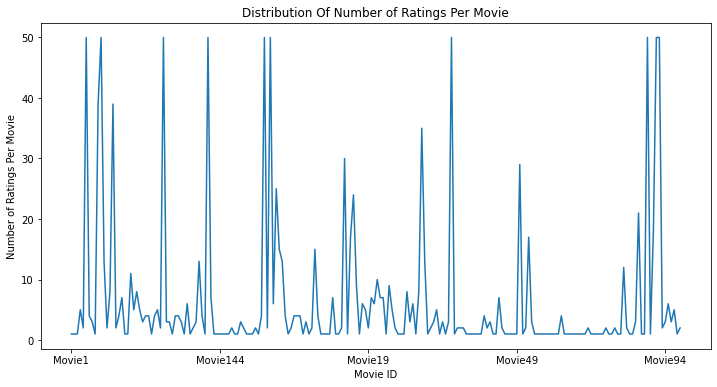

In [24]:
# plot
plt.figure(figsize=(12, 6))
data_cnt1.plot()

# annotate
plt.title('Distribution Of Number of Ratings Per Movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings Per Movie')
plt.show()

#### Distribution Of Number of Ratings Per User

In [25]:
# Number of ratings per user
data_cnt2 = melt_df.groupby('user_id')['rating'].count().clip(upper=50)
data_cnt2

user_id
A0047322388NOTO4N8SKD    1
A00473363TJ8YSZ3YAGG9    1
A1004AX2J2HXGL           1
A100CQXJ6D44T9           1
A100Z2S0880G9A           1
                        ..
AZT7WWYF4YVJA            1
AZVER2EPLYDZ9            1
AZY4RYP9948K9            1
AZYJ9TS07B02W            1
AZZ1KF8RAO1BR            1
Name: rating, Length: 4848, dtype: int64

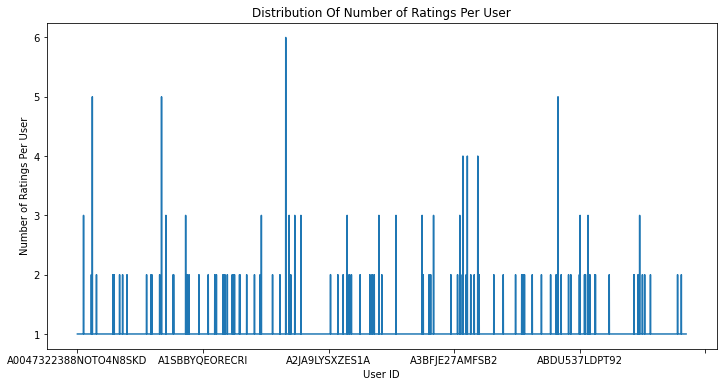

In [27]:
# plot
plt.figure(figsize=(12, 6))
data_cnt2.plot()

# annotate
plt.title('Distribution Of Number of Ratings Per User')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings Per User')
plt.show()

Most of the user rate only around 1 - 2 movies, this makes the model less robust to predict

#### Prediction Anlysis

In [147]:
# Find the minimum rating
melt_df.rating.min() 

1.0

In [148]:
# Find the maximum rating
melt_df.rating.max() 

5.0

In [149]:
# Load the data to surprise
reader = Reader(rating_scale=(1, 5))
data_amazon = Dataset.load_from_df(melt_df[['user_id', 'Movie', 'rating']], reader)

In [150]:
# Setting parameters for grid search for technique optimization
sim_options = {
    "name": ["cosine","msd", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

# Load grid search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3, n_jobs=8)
gs.fit(data_amazon)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.1999065261454958
{'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}}


In [151]:
# Configures the KNNWithMeans function
# Recommender function
from surprise import KNNWithMeans

# To use user-based msd similarity
sim_options = {
    "name": "pearson_baseline",
    "user_based": False,  # Compute  similarities between users
}
algo = KNNWithMeans(sim_options=sim_options)

In [152]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data_amazon, test_size=0.2)
# train the data
algo.fit(trainset)
# preditions
predictions_amazon = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [153]:
predictions_amazon

[Prediction(uid='A17XGI3M7SSN4J', iid='Movie127', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2L0G56BNOTX6S', iid='Movie16', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A40W0OPSWECA6', iid='Movie16', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3KGAJ86I4T73J', iid='Movie16', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1968MG1IR517T', iid='Movie127', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2TIDREWJMOHF3', iid='Movie127', r_ui=5.0, est=4.39025, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1HN5GTSSC8U2W', iid='Movie16', r_ui=4.0, est=4.39025, details={'was_impossible': True, 'reas

In [154]:
pred_amazon = pd.DataFrame(predictions_amazon)
pred_amazon

,uid,iid,r_ui,est,details
0,A17XGI3M7SSN4J,Movie127,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
1,A2L0G56BNOTX6S,Movie16,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
2,A40W0OPSWECA6,Movie16,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
3,A3KGAJ86I4T73J,Movie16,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
4,A1968MG1IR517T,Movie127,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
...,...,...,...,...,...
995,A9AKW5ZRNGWWH,Movie43,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
996,A17MM7I77G1025,Movie52,3.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
997,A2X79NC4QQGNQA,Movie127,1.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."
998,A1X90SEW99DK3G,Movie54,5.0,4.39025,"{'was_impossible': True, 'reason': 'User and/o..."


In [155]:
accuracy.rmse(predictions)

RMSE: 0.8947


0.8947013813605693

In [156]:
pred_amazon['error'] = abs(pred_amazon['est'] - pred_amazon['r_ui'])
pred_amazon.sort_values(by='error')[:10]

,uid,iid,r_ui,est,details,error
275,A1JN58PTDXXT63,Movie89,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
821,AQ8DU6XVA3USJ,Movie29,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
520,ABC8FXLD7W528,Movie188,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",0.0
778,A29G2JU8RWNI73,Movie121,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",0.0
321,A1TN0V94A3ECSH,Movie39,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",0.0
312,A1ISBRQ8WUFE41,Movie189,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",0.0
483,A1LBGXE29GG1IR,Movie89,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
725,AP3B615GM191G,Movie89,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
289,A36ZCBPPL2MSRG,Movie92,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
758,A2AKR3QR28W09U,Movie188,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0


In [158]:
# Make a prediction for user A1JN58PTDXXT63 with Movie89
prediction = algo.predict('A1JN58PTDXXT63', 'Movie89')
prediction.est

5